
# How to train a Deep Q Network

* **Author:** PL team
* **License:** CC BY-SA
* **Generated:** 2022-04-28T08:05:34.347059

Main takeaways:

1. RL has the same flow as previous models we have seen, with a few additions
2. Handle unsupervised learning by using an IterableDataset where the dataset itself is constantly updated during training
3. Each training step carries has the agent taking an action in the environment and storing the experience in the IterableDataset


---
Open in [Open In Colab{height="20px" width="117px"}](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/lightning_examples/reinforce-learning-DQN.ipynb)

Give us a ⭐ [on Github](https://www.github.com/PytorchLightning/pytorch-lightning/)
| Check out [the documentation](https://pytorch-lightning.readthedocs.io/en/stable/)
| Join us [on Slack](https://www.pytorchlightning.ai/community)

## Setup
This notebook requires some packages besides pytorch-lightning.

In [1]:
! pip install --quiet "ipython[notebook]" "seaborn" "torchmetrics>=0.6" "pygame" "gym" "pandas" "pytorch-lightning>=1.4" "torch>=1.6, <1.9"

You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
import os
from collections import OrderedDict, deque, namedtuple
from typing import Iterator, List, Tuple

import gym
import numpy as np
import pandas as pd
import seaborn as sn
import torch
from IPython.core.display import display
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import CSVLogger
from torch import Tensor, nn
from torch.optim import Adam, Optimizer
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")

In [3]:
class DQN(nn.Module):
    """Simple MLP network."""

    def __init__(self, obs_size: int, n_actions: int, hidden_size: int = 128):
        """
        Args:
            obs_size: observation/state size of the environment
            n_actions: number of discrete actions available in the environment
            hidden_size: size of hidden layers
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions),
        )

    def forward(self, x):
        return self.net(x.float())

### Memory

In [4]:

# Named tuple for storing experience steps gathered in training
Experience = namedtuple(
    "Experience",
    field_names=["state", "action", "reward", "done", "new_state"],
)

In [5]:
class ReplayBuffer:
    """Replay Buffer for storing past experiences allowing the agent to learn from them.

    Args:
        capacity: size of the buffer
    """

    def __init__(self, capacity: int) -> None:
        self.buffer = deque(maxlen=capacity)

    def __len__(self) -> None:
        return len(self.buffer)

    def append(self, experience: Experience) -> None:
        """Add experience to the buffer.

        Args:
            experience: tuple (state, action, reward, done, new_state)
        """
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> Tuple:
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*(self.buffer[idx] for idx in indices))

        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(dones, dtype=bool),
            np.array(next_states),
        )

In [6]:
class RLDataset(IterableDataset):
    """Iterable Dataset containing the ExperienceBuffer which will be updated with new experiences during training.

    Args:
        buffer: replay buffer
        sample_size: number of experiences to sample at a time
    """

    def __init__(self, buffer: ReplayBuffer, sample_size: int = 200) -> None:
        self.buffer = buffer
        self.sample_size = sample_size

    def __iter__(self) -> Iterator[Tuple]:
        states, actions, rewards, dones, new_states = self.buffer.sample(self.sample_size)
        for i in range(len(dones)):
            yield states[i], actions[i], rewards[i], dones[i], new_states[i]

### Agent

In [7]:
class Agent:
    """Base Agent class handeling the interaction with the environment."""

    def __init__(self, env: gym.Env, replay_buffer: ReplayBuffer) -> None:
        """
        Args:
            env: training environment
            replay_buffer: replay buffer storing experiences
        """
        self.env = env
        self.replay_buffer = replay_buffer
        self.reset()
        self.state = self.env.reset()

    def reset(self) -> None:
        """Resents the environment and updates the state."""
        self.state = self.env.reset()

    def get_action(self, net: nn.Module, epsilon: float, device: str) -> int:
        """Using the given network, decide what action to carry out using an epsilon-greedy policy.

        Args:
            net: DQN network
            epsilon: value to determine likelihood of taking a random action
            device: current device

        Returns:
            action
        """
        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state = torch.tensor([self.state])

            if device not in ["cpu"]:
                state = state.cuda(device)

            q_values = net(state)
            _, action = torch.max(q_values, dim=1)
            action = int(action.item())

        return action

    @torch.no_grad()
    def play_step(
        self,
        net: nn.Module,
        epsilon: float = 0.0,
        device: str = "cpu",
    ) -> Tuple[float, bool]:
        """Carries out a single interaction step between the agent and the environment.

        Args:
            net: DQN network
            epsilon: value to determine likelihood of taking a random action
            device: current device

        Returns:
            reward, done
        """

        action = self.get_action(net, epsilon, device)

        # do step in the environment
        new_state, reward, done, _ = self.env.step(action)

        exp = Experience(self.state, action, reward, done, new_state)

        self.replay_buffer.append(exp)

        self.state = new_state
        if done:
            self.reset()
        return reward, done

### DQN Lightning Module

In [8]:
class DQNLightning(LightningModule):
    """Basic DQN Model."""

    def __init__(
        self,
        batch_size: int = 16,
        lr: float = 1e-2,
        env: str = "CartPole-v0",
        gamma: float = 0.99,
        sync_rate: int = 10,
        replay_size: int = 1000,
        warm_start_size: int = 1000,
        eps_last_frame: int = 1000,
        eps_start: float = 1.0,
        eps_end: float = 0.01,
        episode_length: int = 200,
        warm_start_steps: int = 1000,
    ) -> None:
        """
        Args:
            batch_size: size of the batches")
            lr: learning rate
            env: gym environment tag
            gamma: discount factor
            sync_rate: how many frames do we update the target network
            replay_size: capacity of the replay buffer
            warm_start_size: how many samples do we use to fill our buffer at the start of training
            eps_last_frame: what frame should epsilon stop decaying
            eps_start: starting value of epsilon
            eps_end: final value of epsilon
            episode_length: max length of an episode
            warm_start_steps: max episode reward in the environment
        """
        super().__init__()
        self.save_hyperparameters()

        self.env = gym.make(self.hparams.env)
        obs_size = self.env.observation_space.shape[0]
        n_actions = self.env.action_space.n

        self.net = DQN(obs_size, n_actions)
        self.target_net = DQN(obs_size, n_actions)

        self.buffer = ReplayBuffer(self.hparams.replay_size)
        self.agent = Agent(self.env, self.buffer)
        self.total_reward = 0
        self.episode_reward = 0
        self.populate(self.hparams.warm_start_steps)

    def populate(self, steps: int = 1000) -> None:
        """Carries out several random steps through the environment to initially fill up the replay buffer with
        experiences.

        Args:
            steps: number of random steps to populate the buffer with
        """
        for _ in range(steps):
            self.agent.play_step(self.net, epsilon=1.0)

    def forward(self, x: Tensor) -> Tensor:
        """Passes in a state x through the network and gets the q_values of each action as an output.

        Args:
            x: environment state

        Returns:
            q values
        """
        output = self.net(x)
        return output

    def dqn_mse_loss(self, batch: Tuple[Tensor, Tensor]) -> Tensor:
        """Calculates the mse loss using a mini batch from the replay buffer.

        Args:
            batch: current mini batch of replay data

        Returns:
            loss
        """
        states, actions, rewards, dones, next_states = batch

        state_action_values = self.net(states).gather(1, actions.long().unsqueeze(-1)).squeeze(-1)

        with torch.no_grad():
            next_state_values = self.target_net(next_states).max(1)[0]
            next_state_values[dones] = 0.0
            next_state_values = next_state_values.detach()

        expected_state_action_values = next_state_values * self.hparams.gamma + rewards

        return nn.MSELoss()(state_action_values, expected_state_action_values)

    def get_epsilon(self, start: int, end: int, frames: int) -> float:
        if self.global_step > frames:
            return end
        return start - (self.global_step / frames) * (start - end)

    def training_step(self, batch: Tuple[Tensor, Tensor], nb_batch) -> OrderedDict:
        """Carries out a single step through the environment to update the replay buffer. Then calculates loss
        based on the minibatch recieved.

        Args:
            batch: current mini batch of replay data
            nb_batch: batch number

        Returns:
            Training loss and log metrics
        """
        device = self.get_device(batch)
        epsilon = self.get_epsilon(self.hparams.eps_start, self.hparams.eps_end, self.hparams.eps_last_frame)
        self.log("epsilon", epsilon)

        # step through environment with agent
        reward, done = self.agent.play_step(self.net, epsilon, device)
        self.episode_reward += reward
        self.log("episode reward", self.episode_reward)

        # calculates training loss
        loss = self.dqn_mse_loss(batch)

        if done:
            self.total_reward = self.episode_reward
            self.episode_reward = 0

        # Soft update of target network
        if self.global_step % self.hparams.sync_rate == 0:
            self.target_net.load_state_dict(self.net.state_dict())

        self.log_dict(
            {
                "reward": reward,
                "train_loss": loss,
            }
        )
        self.log("total_reward", self.total_reward, prog_bar=True)
        self.log("steps", self.global_step, logger=False, prog_bar=True)

        return loss

    def configure_optimizers(self) -> List[Optimizer]:
        """Initialize Adam optimizer."""
        optimizer = Adam(self.net.parameters(), lr=self.hparams.lr)
        return optimizer

    def __dataloader(self) -> DataLoader:
        """Initialize the Replay Buffer dataset used for retrieving experiences."""
        dataset = RLDataset(self.buffer, self.hparams.episode_length)
        dataloader = DataLoader(
            dataset=dataset,
            batch_size=self.hparams.batch_size,
        )
        return dataloader

    def train_dataloader(self) -> DataLoader:
        """Get train loader."""
        return self.__dataloader()

    def get_device(self, batch) -> str:
        """Retrieve device currently being used by minibatch."""
        return batch[0].device.index if self.on_gpu else "cpu"

### Trainer

In [9]:

model = DQNLightning()

trainer = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=150,
    val_check_interval=50,
    logger=CSVLogger(save_dir="logs/"),
)

trainer.fit(model)

GPU available: True, used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name       | Type | Params
------------------------------------
0 | net        | DQN  | 898   
1 | target_net | DQN  | 898   
------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)


/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:229: UserWarning: You called `self.log('total_reward', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:229: UserWarning: You called `self.log('steps', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


,epsilon,episode reward,reward,train_loss,total_reward
epoch,,,,,
3,0.95149,5.0,1.0,0.189056,22.0
7,0.90199,15.0,1.0,1.432721,12.0
11,0.85249,18.0,1.0,30.838800,14.0
15,0.80299,68.0,1.0,3.394485,14.0
19,0.75349,21.0,1.0,18.886366,15.0


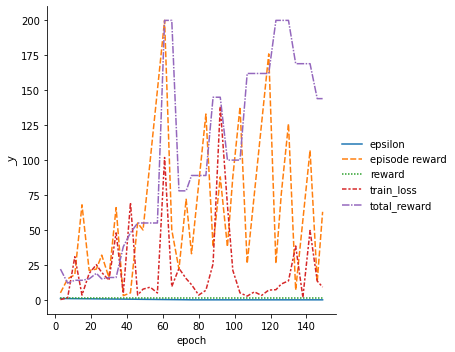

In [10]:

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

## Congratulations - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning
movement, you can do so in the following ways!

### Star [Lightning](https://github.com/PyTorchLightning/pytorch-lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool
tools we're building.

### Join our [Slack](https://www.pytorchlightning.ai/community)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself
and share your interests in `#general` channel


### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to
[Lightning](https://github.com/PyTorchLightning/pytorch-lightning) or [Bolt](https://github.com/PyTorchLightning/lightning-bolts)
GitHub Issues page and filter for "good first issue".

* [Lightning good first issue](https://github.com/PyTorchLightning/pytorch-lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/PyTorchLightning/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

[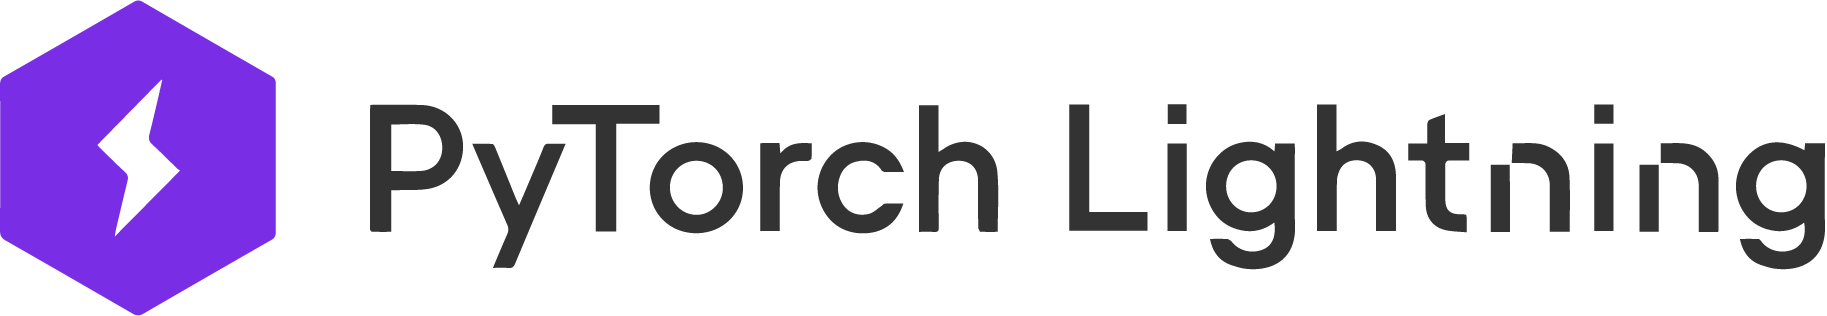{height="60px" width="240px"}](https://pytorchlightning.ai)